# Realtime Classification

Let say you want to cut your realtime recording audio by using VAD after that classify using classification models, you can do that with Malaya-Speech!

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-classification](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-classification).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [9]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

### Load VAD model

Fastest and common model people use, is webrtc. Read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

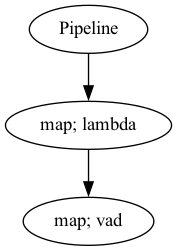

In [2]:
webrtc = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(webrtc)
)
p_vad.visualize()

Starting malaya-speech 1.4.0, streaming always returned a float32 array between -1 and +1 values.

### Streaming interface

```python
def stream(
    vad_model=None,
    asr_model=None,
    classification_model=None,
    sample_rate: int = 16000,
    segment_length: int = 2560,
    num_padding_frames: int = 20,
    ratio: float = 0.75,
    min_length: float = 0.1,
    max_length: float = 10.0,
    realtime_print: bool = True,
    **kwargs,
):
    """
    Stream an audio using pyaudio library.

    Parameters
    ----------
    vad_model: object, optional (default=None)
        vad model / pipeline.
    asr_model: object, optional (default=None)
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object, optional (default=None)
        classification pipeline, will classify each subsamples realtime.
    device: None, optional (default=None)
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    segment_length: int, optional (default=2560)
        usually derived from asr_model.segment_length * asr_model.hop_length,
        size of audio chunks, actual size in term of second is `segment_length` / `sample_rate`.
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (second) to accept a subsample.
    max_length: float, optional (default=10.0)
        maximum length (second) to accept a subsample.
    realtime_print: bool, optional (default=True)
        Will print results for ASR.
    **kwargs: vector argument
        vector argument pass to malaya_speech.streaming.pyaudio.Audio interface.

    Returns
    -------
    result : List[dict]
    """
```

### Check available devices

In [3]:
import sounddevice

sounddevice.query_devices()

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

By default it will use `0` index.

### Load Classification models

In this example, I am going to use 3 different modules, gender detection, language detection and age detection.

In [4]:
gender_model = malaya_speech.gender.deep_model(model = 'vggvox-v2')
language_detection_model = malaya_speech.language_detection.deep_model(model = 'vggvox-v2')
age_model = malaya_speech.age_detection.deep_model(model = 'vggvox-v2')

/Users/huseinzolkepli/Documents/dev/malaya-speech/malaya_speech/utils/featurization.py:38: FutureWarning: Pass sr=16000, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.mel_basis = librosa.filters.mel(


### Classification Pipeline

In this example, I just keep it simple. **And needs to end with `classification` map or else the streaming interface will throw an error**.

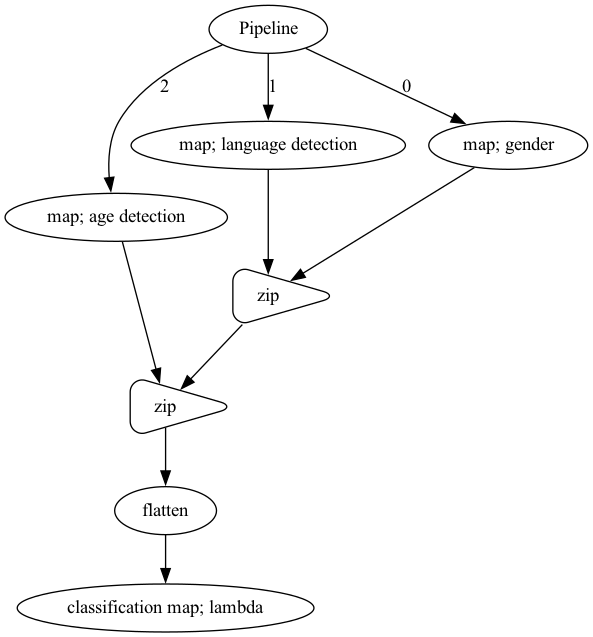

In [5]:
p_classification = Pipeline()
to_float = p_classification
gender = to_float.map(gender_model)
language_detection = to_float.map(language_detection_model)
age_detection = to_float.map(age_model)
combined = gender.zip(language_detection).zip(age_detection).flatten()
combined.map(lambda x: x, name = 'classification')

p_classification.visualize()

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [11]:
samples = malaya_speech.streaming.pyaudio.stream(p_vad, classification_model = p_classification,
                                                segment_length = 320)

(['male', 'others', 'teens']) (['male', 'others', 'teens']) (['male', 'others', 'teens']) (['female', 'english', 'teens']) (['male', 'others', 'teens']) (['male', 'others', 'teens']) 

In [12]:
samples

[{'wav_data': array([-0.00345457, -0.0032946 , -0.00301315, ...,  0.00223406,
          0.00202652,  0.00163344], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 16, 29, 28, 534089),
  'classification_model': ['male', 'others', 'teens']},
 {'wav_data': array([-0.00067088, -0.00044385, -0.0005716 , ..., -0.00282512,
         -0.00334047, -0.00384063], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 16, 29, 32, 193274),
  'classification_model': ['male', 'others', 'teens']},
 {'wav_data': array([-0.00188409, -0.00239474, -0.00268455, ...,  0.00144703,
          0.00123731,  0.00090965], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 16, 29, 34, 113255),
  'classification_model': ['male', 'others', 'teens']},
 {'wav_data': array([-0.00127463, -0.00137094, -0.00147386, ...,  0.00097433,
          0.00168371,  0.00204899], dtype=float32),
  'timestamp': datetime.datetime(2023, 2, 16, 16, 29, 35, 693264),
  'classification_model': ['female', 'englis

In [13]:
import IPython.display as ipd
import numpy as np

In [14]:
ipd.Audio(samples[-1]['wav_data'], rate = 16000)

In [15]:
ipd.Audio(np.concatenate([s['wav_data'] for s in samples]), rate = 16000)